##**10 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge**
https://www.kaggle.com/competitions/mercari-price-suggestion-challenge/data

일본의 대형 온라인 쇼핑몰인 Mercari 사의 제품에 대해 가격을 예측하는 과제
- 제품에 대한 여러 속성 및 제품 설명 등의 텍스트 데이터를 기반으로 예측 가격을 제공



```
- train_id : 데이터 id
- name : 제품명
- item_condition_id : 판매자가 제공하는 제품 상태
- category_name : 카테고리 명
- brand_name : 브랜드 이름
- price : 제품 가격, 예측을 위한 타깃 속성
- shipping : 배송비 무료 여부, 1이면 무료(판매자가 지불), 0이면 유료(구매자 지불)
- item_description : 제품에 대한 설명
```

- `price` : 예측해야 할 타깃, 회귀
- item_description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀를 수행

###**데이터 전처리**

In [1]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/drive/MyDrive/ESAA/23-1/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


- 1482535개의 레코드를 가지고 있는 데이터 세트
- 피처의 타입과 Null 여부를 확인

In [2]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


- `brand_name` 칼럼의 경우 많은 Null 값을 가지고 있음
- target 칼럼의 데이터 분포도 살펴보기

<ipython-input-3-12402ca32828>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df, kde=False)


<Axes: xlabel='price'>

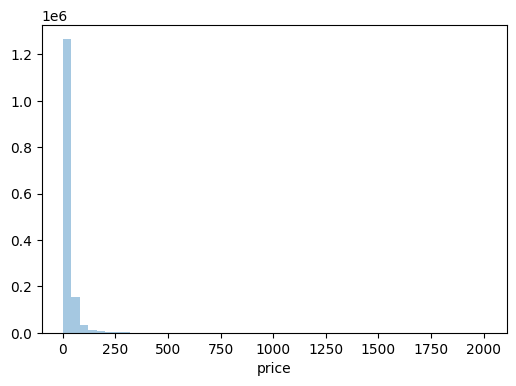

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df, kde=False)

- price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡되어 분포되어 있음
- 로그 변환

<ipython-input-4-73f0fb165241>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df, kde=False)


<Axes: xlabel='price'>

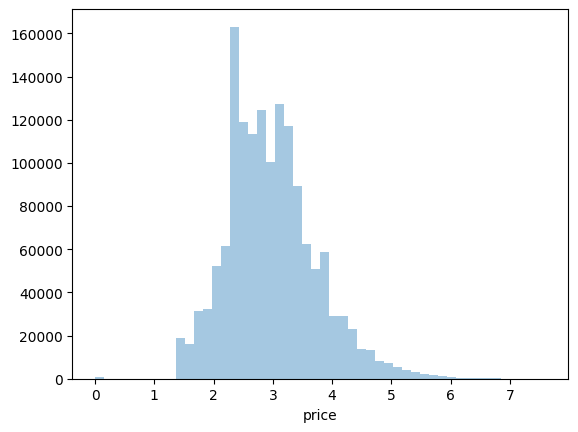

In [4]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

In [5]:
mercari_df['price']=np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [6]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


- `shipping` : 배송비 유무, 값이 비교적 균일함
- `item_condition_id` : 판매자가 제공하는 제품 상태, 1,2,3이 주를 이루고 있음
- `item_description` : null 값은 별로 없지만, description에 대한 별도 설명이 없는 경우 'No description yet'

In [7]:
boolean_cond = mercari_df['item_description']== 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

In [8]:
#apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name) :
  try :
    return category_name.split('/')
  except :
    return ['Other_Null', 'Other_Null', 'Other_Null']

#위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'],  mercari_df['cat_so'] = \
zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

#대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형:\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수:', mercari_df['cat_jung'].nunique())
print('소분류 개수:', mercari_df['cat_so'].nunique())

대분류 유형:
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 개수: 114
소분류 개수: 871


In [9]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

#각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야 한다.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

###**피처 인코딩과 피처 벡터화**
칼럼을 숫자형 코드 값으로 인코딩, 텍스트형 칼럼에 대해서는 피처 벡터화 변환
- 선형 회귀 : 원-핫 인코딩 선호
- 피처 벡터화 : 짧은 텍스트는 Count 기반 벡터화, 긴 텍스트는 TF-IDF 기반 벡터화 적용

In [10]:
print('brand name의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 :\n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수 : 4810
brand name sample 5건 :
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


brand name
- 대부분 명료한 문자열로 되어 있으므로 피처 벡터화 필요 없음
- brand_name 4810건, 원-핫 인코딩 변환

In [11]:
print('name의 종류 개수 :', mercari_df['name'].nunique())
print('name sample 10건 : \n', mercari_df['name'][:10])

name의 종류 개수 : 1225273
name sample 10건 : 
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


**Name**
- 종류가 1225273가지로 매우 많음
- 전체 데이터가 1482535개이므로 개별적으로 거의 고유한 상품명을 가짐
- 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 되어 있으므로 Count 기반으로 피처 벡터화 변환 적용

**category_name**
- 전처리를 통해 대, 중, 소 분류의 세 개의 칼럼으로 분리됨
- cat_dae, cat_jung, cat_so 칼럼 원-핫 인코딩

**shipping**
- 배송비 무료 여부로 0,1 두 가지 유형 값, 원-핫 인코딩

**item_condition_id**
- 상품 상태, 1,2,3,4,5의 다섯 가지 유형 값, 원-핫 인코딩




In [12]:
pd.set_option('max_colwidth', 200)

#item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

**item_description**
- 상품에 대한 간단 설명으로 데이터 세트에서 가장 긴 텍스트를 가지고 있음
- 평균 문자열이 145로 비교적 크므로, TF-IDF 변환

---
주요 칼럼 인코딩 및 피처 벡터화

In [13]:
#name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

#item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


CountVectorizer, TfidfVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬 형태
- 희소 행렬 객체 변수인 X_name, X_descp를 새로 결합해 새로운 데이터 세트로 구성
- 앞으로 인코딩 될 cat_dae, cat_jung, cat_so, brand_name, shipping, item_condition_id도 모두 X_name, X_descp와 결합돼 ML 모델을 실행하는 기반 데이터 세트로 재구성되어야 함
- LabelBinarizer 클래스는 희소 행렬 형태의 원-핫 인코딩 변환을 지원
  - 생성 시 sparse_out=True 파라미터 설정
- 개별 칼럼으로 만들어진 희소 행렬은 사이파이 패키지 sparse 모듈의 hstack() 함수를 이용해 결합

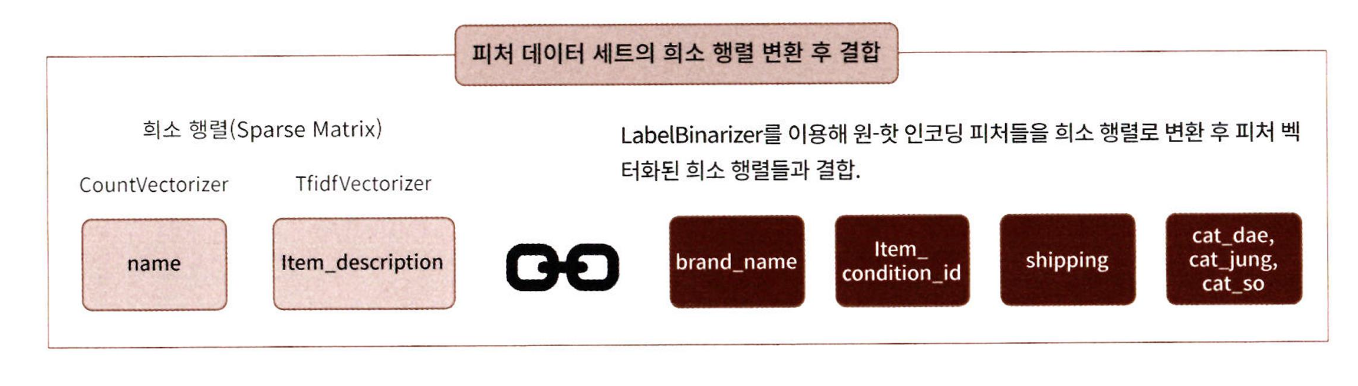

In [14]:
from sklearn.preprocessing import LabelBinarizer

#brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

#cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [15]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


- 인코딩 변환된 데이터 세트가 CSR 형태로 변환된 csr_matrix 타입
---
hstack() 이용해 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 결합
- 데이터 타입과 크기만 확인하고 메모리에서 삭제

In [16]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

#hstack함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

#데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


0

- csr_matrix 타입, 161569개의 피처를 가짐
- price 값을 예측할 수 있는 모델 만들기

###**릿지 회귀 모델 구축 및 평가**
평가 로직 함수화 : RMSLE(Root Mean Square Logarithmic Error)
- RMSE와 유사하나 오류 값에 로그를 취해 RMSE를 구하는 방식
- 낮은 가격(price)보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제하기 위해 방식을 도입

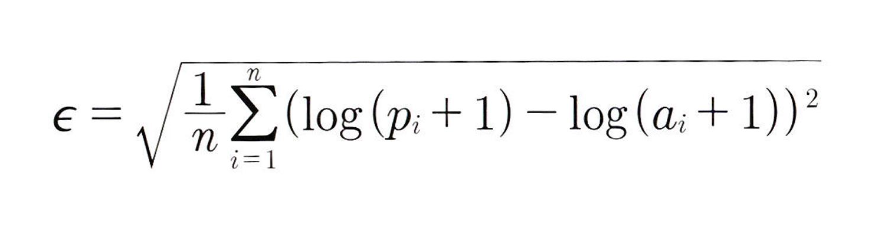

학습할 모델이 사용할 price 값은 로그 값으로 변환된 price 값이므로 예측도 로그로 변환한 데이터 값 수준의 price 값 예측

In [17]:
def rmsle(y, y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred),2)))

def evaluate_org_price(y_test, preds):

  #원본 데이터는 log1p로 변환되었으므로 expm1로 원복 필요
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  #rmsle로 RMSLE값 추출
  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

In [18]:
#학습용 데이터 생성, 모델 학습/예측
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
  #scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
  X = hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size = 0.2, random_state=156)

  #모델 학습 및 예측
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  del X, X_train, X_test, y_train
  gc.collect()

  return preds, y_test

Mercari 상품 가격 예측에 item_description과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는지 알아보자.

In [19]:
linear_model = Ridge(solver = 'lsqr', fit_intercept = False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.4983990938999374
Item Description을 포함한 rmsle 값: 0.4680329023962086


- Item Description을 포함했을 때 rmsle 값이 많이 감소함, 중요한 변수

###**Light GBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가**


In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators = 200, learning_rate = 0.5, num_leaves = 125, random_state = 156)
lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list = sparse_matrix_list)
print('LightGBM rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

- 앙상블

In [ ]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble 한 최종 rmsle 값:', evaluate_org_price(y_test, preds))

##**11 정리**
머신러닝 기반의 텍스트 분석 프로세스
 1. 텍스트 사전 정제 작업 등의 텍스트 정규화 작업을 수행
  - 텍스트 클렌징 및 대소문자 변경, 단어 토큰화, 의미 없는 단어 필터링, 어근 추출 등
 2. 피처 벡터화로 변환
  - BOW의 대표 방식인 Count 기반, TF-IDF 기반 피처 벡터화
  - 일반적으로 문서의 문장이 긴 경우 TF-IDF 기반의 피처 벡터가 더 정확한 결과를 도출하는 데 도움이 됨
  - 이렇게 만들어진 피처 벡터 데이터 세트는 희소 행렬이며, 머신러닝 모델은 이러한 의소 행렬 기반에서 최적화 되어야 함
 3. 피처 벡터 데이터 세트에 머신러닝 모델 학습, 예측, 평가
  - 감성분석
      - 지도학습 기반 긍정/부정 이진 분류를 적용한 방식
      - SentiWordNet, VADER와 같은 감성 사전 Lexicon을 이용한 방식
  - 토픽 모델링
      - LDA(Latent Dirichlet Allocation)를 이용해 뉴스그룹 내의 많은 문서들이 공통적으로 가지는 토픽 추출
  - 텍스트 군집화
      - k-means 군집화 기법을 이용해 비슷한 문서들끼리 군집화
  - 텍스트 유사도
      - 코사인 유사도
